# Data Scientist Technical Test

Ross Guthery

2 November 2022

In [1]:
# Import packages.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from toolbox import Data, FeatureEngineerer, Modeller

# Standardize figure size.
plt.rcParams["figure.figsize"] = (10, 8)

/Users/rossguthery/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### 1. Data Collection and Cleaning

To manage the reading in and cleaning of the data needed to complete this test, I wrote a class called ```Data```. Data collection is obviously straightforward. Data cleaning, however, isn't. The class's private ```clean_data``` function retitles the columns so they are easier to understand, drops columns I either can't use or don't understand, and removes unecessary characters like "_z", "<", "$", and "," from the entries themselves. Furthermore, it ensures each column is the appropriate data type and replaces boolean values like "yes" and "no" with more usable values like ones and zeros. As an aside, it's during this step that I drop the one outlier I found, which is a negative car age. I also drop the only duplicate row I stumbled upon. (I only carry out the last two steps on the training data.)

In [2]:
# Instantiate a Data object for the test and train sets.
test_data: Data = Data(
    train=False, file_path="data/test_auto.csv", index_col=0
)
train_data: Data = Data(
    train=True, file_path="data/train_auto.csv", index_col=0
)

In [3]:
# Call the test and train set Data objects. Doing so fetches the data and cleans
# it in the way outlined above.
test_data()
train_data()

In [4]:
# Display where the null values are in the test and train sets.
pd.concat(
    objs=[train_data.data.isnull().sum(), test_data.data.isnull().sum()],
    keys=['train_nulls', 'test_nulls'],
    axis=1,
)

,train_nulls,test_nulls
target_flag,0,2141
num_kids_driving,0,0
age,6,1
num_kids_home,0,0
income,413,125
is_single_parent,0,0
home_value,428,111
is_married,0,0
is_female,0,0
education,0,0


I spent a fair amount of time reflecting upon how to best manage the null values that appear in the age, job, income, car age, and home value columns of the data sets. In the end, I decided to proceed as follows. First, I replaced the null values in the age and car age columns with the mean of said columns as the mean and median of each are less than one year apart. Next, I removed rows with null values in the job column as the average income earned by blue collar workers, the most common occupation, does not align with the average income earned by those whose occupation isn't listed ($59,282 vs. $118,457). Moreover, the standard deviation of the latter group's income distribution is $58,834, which essentially means that five of the eight possible occupations are within one standard deviation of the their average income. Furthermore, I also removed rows with null values in either the income or home value columns as, in my opinion, inferring a value for either could portend a gross misjudgement on our part. An income of zero could mean that someone is unemployed, just as a home value of zero could mean that someone is a renter. In other words, it would be unjust to make an assumption here. The final component of this step consisted of removing null values in the test set's target column. (It's obvious why we don't have any data here.)

In [5]:
# Drop null values in the test and train sets according to the strategy above.
test_data.deal_with_nulls()
train_data.deal_with_nulls()

In [6]:
# Display the first five rows of the train set to get a feel for the clean data.
train_data.data.head()

,target_flag,num_kids_driving,age,num_kids_home,income,is_single_parent,home_value,is_married,is_female,education,...,travel_time,for_commercial_use,bluebook_value,car_type,is_red_car,last_claim_value,claim_frequency,was_revoked,car_age,is_urban
0,0,0,60.0,0,67349.0,0,0.0,0,0,phd,...,14,0,14230,minivan,1,4461,2,0,18.0,1
1,0,0,43.0,0,91449.0,0,257252.0,0,0,high_school,...,22,1,14940,minivan,1,0,0,0,1.0,1
2,0,0,35.0,1,16039.0,0,124191.0,1,1,high_school,...,5,0,4010,suv,0,38690,2,0,10.0,1
4,0,0,50.0,0,114986.0,0,243925.0,1,1,phd,...,36,0,18000,suv,0,19217,2,1,17.0,1
5,1,0,34.0,1,125301.0,1,0.0,0,1,bachelors,...,46,1,17430,sports_car,0,0,0,0,7.0,1


### 2. Feature Engineering

Feature engineering is an important part of the machine learning pipeline as, in many cases, the models one uses are only as good as the features one puts into them. To manage this process, I wrote the ```FeatureEngineerer``` class, which automatically one-hot encodes all the non-numerical categorical variables upon being called. It also avails the user of several other public functions that create new interaction terms or take the log transformation of variables already present in the data set.

In [7]:
# Instantiate a FeatureEngineerer object for the test and train sets.
test_engineerer: FeatureEngineerer = FeatureEngineerer(data=test_data.data)
train_engineerer: FeatureEngineerer = FeatureEngineerer(data=train_data.data)

In [8]:
# Call the test and train sets FeatureEngineerer objects. This one-hot encodes
# the non-numerical categorical variables.
test_engineerer()
train_engineerer()

Given my background in economics, I know that one possible route to follow when engineering new features is to create interaction terms. We need to first identify the variables in the data set whose interaction is highly correlated. This correlation can be either positive or negative. One way of visualizing the correlation I just described is with a heat map, and I have plotted one below. It suffices to only analyze either above or below the dark blue diagonal as the map is symmetric. Although many relationships stick out, I am going to focus on those that relate non-car characteristics to car characterisitcs given the context of the problem. These relationships are:
- Being female and having an SUV,
- Being female and having a red car, and
- Having a high school education and a car's age.

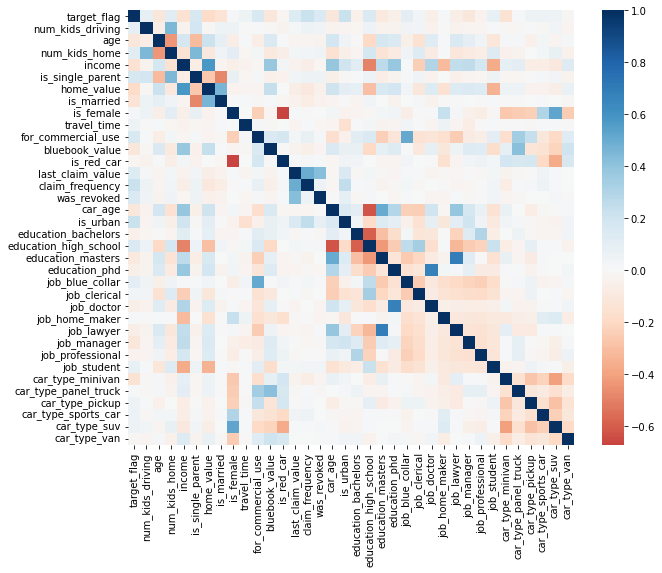

In [9]:
# Plot heat map to show correlation between explanatory variables.
sns.heatmap(data=train_engineerer.data.corr(), cmap="RdBu", center=0)
plt.show()

In [10]:
# Add the interaction variables mentioned above to the test and train sets.
test_engineerer.get_interaction_terms()
train_engineerer.get_interaction_terms()

In [11]:
# Display the first five rows of the train set to get a feel for the engineered data.
train_engineerer.data.head(5)

,target_flag,num_kids_driving,age,num_kids_home,income,is_single_parent,home_value,is_married,is_female,travel_time,...,job_student,car_type_minivan,car_type_panel_truck,car_type_pickup,car_type_sports_car,car_type_suv,car_type_van,female_suv,female_red_car,high_school_car_age
0,0,0,60.0,0,67349.0,0,0.0,0,0,14,...,0,1,0,0,0,0,0,0,0,0.0
1,0,0,43.0,0,91449.0,0,257252.0,0,0,22,...,0,1,0,0,0,0,0,0,0,1.0
2,0,0,35.0,1,16039.0,0,124191.0,1,1,5,...,0,0,0,0,0,1,0,1,0,10.0
4,0,0,50.0,0,114986.0,0,243925.0,1,1,36,...,0,0,0,0,0,1,0,1,0,0.0
5,1,0,34.0,1,125301.0,1,0.0,0,1,46,...,0,0,0,0,1,0,0,0,0,0.0


### 3. Modelling

To manage the modelling component of the machine learning pipline, I wrote the ```Modeller``` class, which manages everything to do with modelling the cleaned and feature engineered data. This includes, but is not limited to, getting the target variable, scaling the data if needed, executing select models within a cross-validation framework, computing model performance, plotting feature importances, and saving predictions made on the test set. As the problem at hand is one of binary classification, this class only works with logistic regressions, support vector classifiers, and catboost classifiers.

Interacting with this class is simple. All one needs to do is instantiate a ```Modeller``` object with the test and train sets as well as with a file path that points to all model configurations. One must also specify which configuration in the file to use (e.g. run_number_1, run_number_2, etc.). Then, all one needs to do is call the object as doing so automatically carries out all the functionalities mentioned above. Importantly, both the feature importance plot and the test set predictions are saved in folders of the appropriate name and are labelled using the run number. This makes testing many different model configurations a breeze! 

I chose to use the F1 score to compare model performances. The combination of two simplier metrics (precision and recall), the F1 score is the harmonic mean of precision and recall and works better on imbalanced data than, for example, accuracy. We are indeed working with imbalanced data as there are 4,708 target flag values equal to 0 and 1,694 equal to 1 in the final train set. The measure weights precision and recall equally and with thus only achieve a high result when both of its constituent measures are high.

In [12]:
# Create a DataFrame to store all model performances.
df_all_runs: pd.DataFrame = pd.DataFrame(
    columns=["run_number", "model", "metric", "best_val_score", "train_score"]
)

##### 3.1 Logistic Regression

The first model that I tried is an elastic net (0.5) logistic regression model. The best performing configuration I found for this model yielded a validation score of 0.55 during a 10-fold cross-validation scheme. Unsurprisingly, the boolean value "is urban" performs quite well, which is to be expected as urban driving environments are much more complex than rural ones. Strangely though, the model performs worse on the whole train set (i.e. being trained and then tested on the whole train set). Given the increased information available to the model as well as the fact that it is being tested on information it has already seen, one would expect the train F1 score to be higher.

,run_number,model,metric,best_val_score,train_score
0,1,logistic_regression,f1,0.552448,0.503085


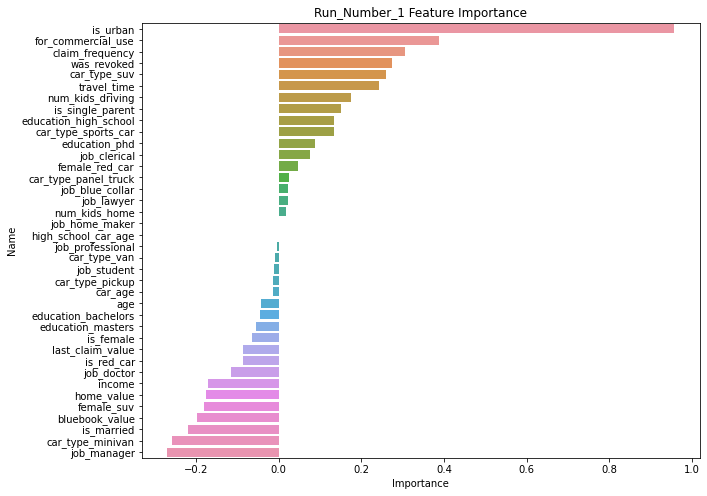

In [13]:
# Instantiate a Modeller object.
run_1: Modeller = Modeller(
    test=test_engineerer.data,
    train=train_engineerer.data,
    config_path="model_configs.yaml",
    entry_point="run_number_1",
)

# Call the Modeller object and store the model's performance.
run_1()
df_all_runs = pd.concat(
    [df_all_runs, run_1.results], axis=0, ignore_index=True
)

# Display the model's results.
run_1.results

##### 3.2 Support Vector Classifier

Having tried regularized logistic regression, I moved onto support vector classifiers as doing so would allow me to simply test both linear and no-linear kernels when classifying the data. While non-linear kernels might better classify the data, they are more difficult to clearly explain, which is something to keep in mind as I believe explainability is important when it comes to insurance.

The first support vector classifier I tried is a regularized linear SVC. The best performing configuration I found for this model yielded a validation score of 0.51 during a 10-fold cross-validation scheme. The "is urban" boolean performs well yet again, but this model also exhibits the strange validation-train score dynamic explained above. Its scores are also lower all around, so we are going to move on.

,run_number,model,metric,best_val_score,train_score
0,2,svc,f1,0.513619,0.466253


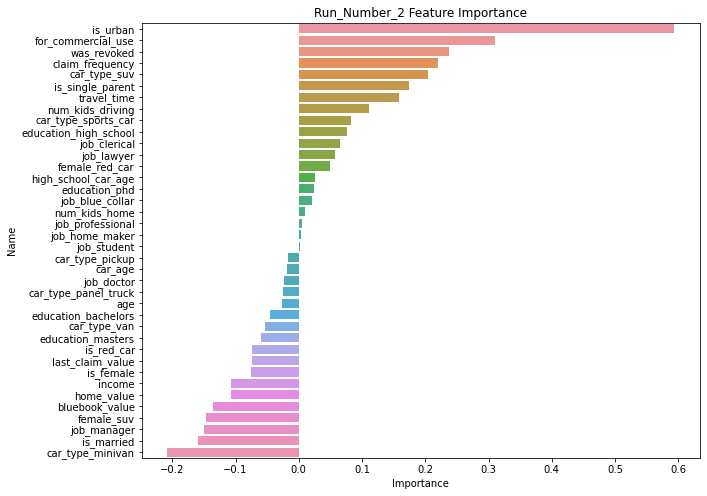

In [14]:
# Instantiate a Modeller object.
run_2: Modeller = Modeller(
    test=test_engineerer.data,
    train=train_engineerer.data,
    config_path="model_configs.yaml",
    entry_point="run_number_2",
)

# Call the Modeller object and store the model's performance.
run_2()
df_all_runs = pd.concat(
    [df_all_runs, run_2.results], axis=0, ignore_index=True
)

# Display the model's results.
run_2.results

The second support vector classifier I tried is a regularized polynomial SVC. The best performing configuration I found for this model yielded a validation score of 0.55 during a 10-fold cross-validation scheme. This model is the first to not exhibit the strange validation-train score dynamic, which is good news. Even if its best validation score is slightly lower than that of the logistic regression, I would still prefer using this one.

In [15]:
# Instantiate a Modeller object.
run_3: Modeller = Modeller(
    test=test_engineerer.data,
    train=train_engineerer.data,
    config_path="model_configs.yaml",
    entry_point="run_number_3",
)

# Call the Modeller object and store the model's performance.
run_3()
df_all_runs = pd.concat(
    [df_all_runs, run_3.results], axis=0, ignore_index=True
)

# Display the model's results.
run_3.results

,run_number,model,metric,best_val_score,train_score
0,3,svc,f1,0.550162,0.762533


The third support vector classifier I tried is a regularized RBF SVC. The best performing configuration I found for this model yielded a validation score of 0.56 during a 10-fold cross-validation scheme. This model also does not exhibit the strange validation-train score dynamic. Moreover, its train F1 score is lower than that of the regularized polynomical SVC (0.66 vs. 0.76). This implies the former generalizes better and is more robust to ovefitting.

In [16]:
# Instantiate a Modeller object.
run_4: Modeller = Modeller(
    test=test_engineerer.data,
    train=train_engineerer.data,
    config_path="model_configs.yaml",
    entry_point="run_number_4",
)

# Call the Modeller object and store the model's performance.
run_4()
df_all_runs = pd.concat(
    [df_all_runs, run_4.results], axis=0, ignore_index=True
)

# Display the model's results.
run_4.results

,run_number,model,metric,best_val_score,train_score
0,4,svc,f1,0.562712,0.66805


##### 3.3 Catboost Classifier

For the last model, I wanted to try some sort of boosted tree model, which for most people means using xgboost. I, however, prefer catboost as I find that it produces better results out of the box and is often more accurate even if it takes longer to train. Hence my choice to implement catboost instead. As was the case with non-linear support vector classifiers, the catboost model is more difficult to explain even if it is possible to make a feature importance plot. The best performing configuration I found for this model yielded a validation score of 0.57 during a 10-fold cross-validation scheme.

,run_number,model,metric,best_val_score,train_score
0,5,catboost,f1,0.570423,0.785568


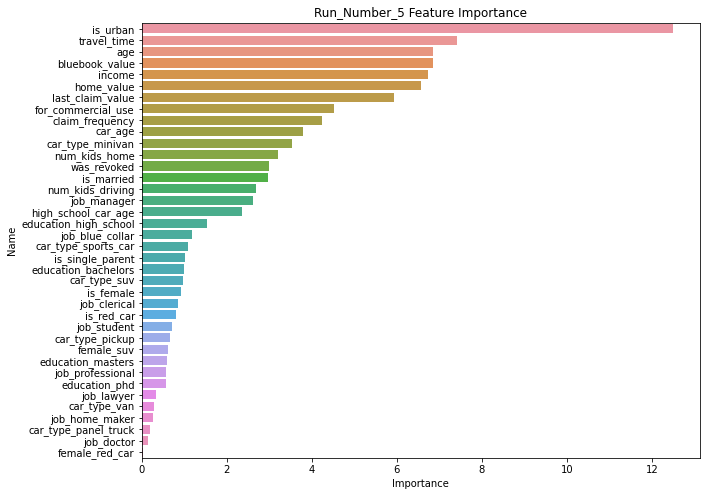

In [17]:
# Instantiate a Modeller object.
run_5: Modeller = Modeller(
    test=test_engineerer.data,
    train=train_engineerer.data,
    config_path="model_configs.yaml",
    entry_point="run_number_5",
)

# Call the Modeller object and store the model's performance.
run_5()
df_all_runs = pd.concat(
    [df_all_runs, run_5.results], axis=0, ignore_index=True
)

# Display the model's results.
run_5.results

### 4. Conclusions

Given each model's respective performance (displayed below), I think I would proceed as follows. First, I would select the catboost classifier model as its validation score is the highest and, unlike the latter two SVC models, we can plot its feature importances for explanability purposes. Next, I would return to the feature engineering stage of the machine learning pipeline. There were several variables I didn't clearly understand and as a result threw out because, in my opinion, it's not just to use information we aren't familiar with and therefore can't explain. It is quite possible that these variables are the most effective when it comes to this machine learning task. In any case, I would improve my understanding of these variables and try to find better ways to engineer them before returning to hyperparameter tuning.

In [18]:
# Display performance of all models.
df_all_runs.head()

,run_number,model,metric,best_val_score,train_score
0,1,logistic_regression,f1,0.552448,0.503085
1,2,svc,f1,0.513619,0.466253
2,3,svc,f1,0.550162,0.762533
3,4,svc,f1,0.562712,0.668050
4,5,catboost,f1,0.570423,0.785568
